<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/073_Mixture_of_Experts_MoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Mixture of Experts (MoE): Architektura GPT-4

W standardowym Transformerze (Dense) każde słowo przechodzi przez te same warstwy.
W MoE zamieniamy warstwę FeedForward (FFN) na zestaw **N Ekspertów**.

**Kluczowe elementy:**
1.  **Eksperci:** Niezależne sieci neuronowe (zazwyczaj proste MLP).
2.  **Gating Network (Router):** Mała sieć, która dla każdego tokena decyduje, których ekspertów uruchomić.
3.  **Top-K:** Zazwyczaj wybieramy tylko 2 najlepszych ekspertów z 8 (Top-2 Gating).

**Zysk:**
*   Model ma np. 8x więcej parametrów (Pojemność wiedzy).
*   Ale koszt obliczeniowy (FLOPs) jest taki sam jak małego modelu (Szybkość).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
D_MODEL = 32      # Wymiar wektora słowa
NUM_EXPERTS = 4   # Liczba ekspertów
TOP_K = 2         # Ilu ekspertów wybieramy dla każdego słowa?

print(f"Symulacja MoE na: {DEVICE}")

Symulacja MoE na: cuda


## 1. Ekspert (Expert Network)

Ekspert to nic innego jak zwykła sieć `FeedForward`, którą robiliśmy w notatniku 46.
W MoE mamy ich po prostu wiele kopii.

In [2]:
class Expert(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_model * 4), # Rozszerzamy
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)  # Zwężamy
        )

    def forward(self, x):
        return self.net(x)

# Stwórzmy listę ekspertów
experts_list = nn.ModuleList([Expert(D_MODEL) for _ in range(NUM_EXPERTS)])
print(f"Stworzono {len(experts_list)} ekspertów.")

Stworzono 4 ekspertów.


## 2. Gating Network (Router)

To jest mózg operacji.
Dla każdego wektora wejściowego $x$, Router wylicza "punkty" dla każdego eksperta.
Następnie bierze **Top-K** (najlepszych dwóch) i normalizuje ich wagi (Softmax).

$$ G(x) = \text{Softmax}(\text{TopK}(W_g \cdot x)) $$

Jeśli Router wybierze Eksperta A (waga 0.7) i Eksperta B (waga 0.3), to wynik jest ważoną sumą ich odpowiedzi.

In [3]:
class MoELayer(nn.Module):
    def __init__(self, d_model, num_experts, top_k):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        
        # Lista Ekspertów
        self.experts = nn.ModuleList([Expert(d_model) for _ in range(num_experts)])
        
        # Router (Mała sieć, która ocenia przydatność eksperta)
        self.gate = nn.Linear(d_model, num_experts)

    def forward(self, x):
        # x shape: [Batch, Seq_Len, D_Model]
        # Spłaszczamy batch i seq, żeby traktować każdy token osobno
        original_shape = x.shape
        x_flat = x.view(-1, original_shape[-1]) 
        
        # 1. Router ocenia (Logity dla każdego eksperta)
        router_logits = self.gate(x_flat) # [Tokens, Num_Experts]
        
        # 2. Wybieramy Top-K
        # values: Wagi (jak pewny jest router)
        # indices: ID wybranych ekspertów
        routing_weights, selected_experts = torch.topk(router_logits, self.top_k, dim=-1)
        
        # 3. Normalizujemy wagi (Softmax tylko na wybranych!)
        routing_weights = F.softmax(routing_weights, dim=-1)
        
        # 4. Uruchamiamy Ekspertów
        # W prawdziwym wydajnym kodzie (CUDA) tutaj dzieje się magia (Sparse Kernel).
        # W Pythonie zrobimy to pętlą dla przejrzystości (wolniej, ale zrozumiale).
        
        final_output = torch.zeros_like(x_flat)
        
        # Iterujemy po każdym tokenie
        for i, token_vec in enumerate(x_flat):
            # Dla każdego tokena bierzemy jego wybranych ekspertów
            for k in range(self.top_k):
                expert_idx = selected_experts[i, k].item()
                weight = routing_weights[i, k]
                
                # Uruchom wybranego eksperta
                expert_out = self.experts[expert_idx](token_vec.unsqueeze(0))
                
                # Dodaj ważony wynik do sumy
                final_output[i] += weight * expert_out.squeeze(0)
        
        return final_output.view(original_shape), selected_experts

# Inicjalizacja MoE
moe = MoELayer(D_MODEL, NUM_EXPERTS, TOP_K).to(DEVICE)
print("Warstwa MoE gotowa.")

Warstwa MoE gotowa.


## Symulacja i Analiza Routera

Wrzucimy do modelu losowe dane (symulacja różnych słów) i zobaczymy, jak Router rozdziela pracę.
Czy Router jest leniwy i zawsze wybiera Eksperta nr 0? (To częsty problem w MoE, zwany **Load Balancing**).

Wejście: torch.Size([1, 100, 32])
Wyjście: torch.Size([1, 100, 32])


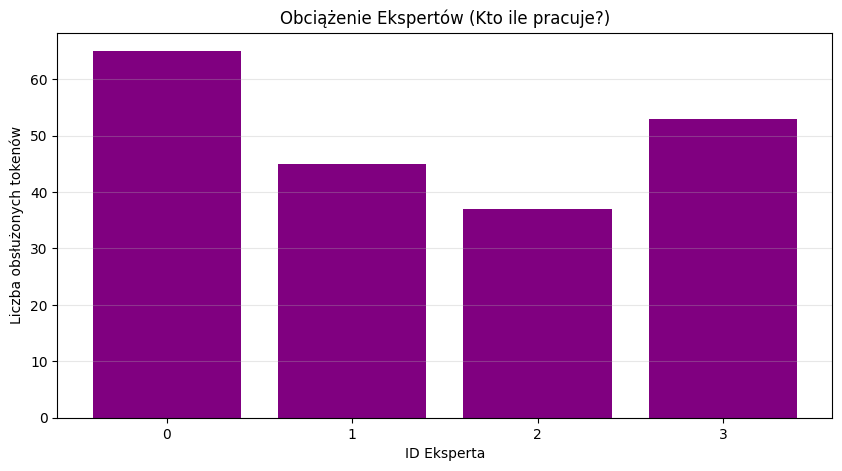

Jeśli słupki są równe -> Router działa dobrze (Load Balanced).
Jeśli jeden słupek dominuje -> Mamy problem (Expert Collapse).


In [4]:
# Dane wejściowe: 100 tokenów
dummy_input = torch.randn(1, 100, D_MODEL).to(DEVICE)

# Przepływ
output, assignments = moe(dummy_input)

print(f"Wejście: {dummy_input.shape}")
print(f"Wyjście: {output.shape}")

# ANALIZA PRZYDZIAŁÓW
# assignments shape: [1, 100, 2] -> [Wszystkie tokeny, Top-2]
flat_assignments = assignments.flatten().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.hist(flat_assignments, bins=range(NUM_EXPERTS+1), align='left', rwidth=0.8, color='purple')
plt.xticks(range(NUM_EXPERTS))
plt.title("Obciążenie Ekspertów (Kto ile pracuje?)")
plt.xlabel("ID Eksperta")
plt.ylabel("Liczba obsłużonych tokenów")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Jeśli słupki są równe -> Router działa dobrze (Load Balanced).")
print("Jeśli jeden słupek dominuje -> Mamy problem (Expert Collapse).")

## 🧠 Podsumowanie: Skalowanie horyzontalne

MoE to sekret skalowania.
Gdybyś chciał zbudować model 10x mądrzejszy (Gęsty), musiałbyś kupić 10x więcej GPU do *uruchomienia* go.
W MoE możesz dodać 100 nowych ekspertów (zwiększyć wiedzę), a koszt generowania tekstu (Inference) prawie nie wzrośnie (bo i tak używasz tylko 2 naraz).

**Problemy inżynierskie:**
1.  **VRAM:** Mimo że obliczenia są szybkie, *wszyscy* eksperci muszą być załadowani do pamięci karty graficznej. MoE wymaga dużo VRAM (np. 80GB A100).
2.  **Expert Collapse:** Router może się "zakochać" w jednym ekspercie i ignorować resztę. Wtedy tracimy zalety MoE. Stosuje się specjalne "Auxiliary Loss", żeby zmuszać Router do sprawiedliwości.